In [1]:
!wget https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?dl=0

!unzip train.zip?dl=0

--2023-12-06 05:21:43--  https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w3zlhing4dkgeyb/train.zip [following]
--2023-12-06 05:21:44--  https://www.dropbox.com/s/raw/w3zlhing4dkgeyb/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc80d66946e47a29606532d75a4d.dl.dropboxusercontent.com/cd/0/inline/CI1n5haF7NZcgpaaYDwqZ3al5unArCJTtmtyYX-6kY3eiVAjL9nrUyeoVu-l1ci393cCHT2fTlkuShttkU5ycHui_GEFaHygJCfnjiuT0vOStPW3xR8ithpzt-JTbTrxbgpGrNC4a-nf5gmkzT9Tkca9/file# [following]
--2023-12-06 05:21:45--  https://uc80d66946e47a29606532d75a4d.dl.dropboxusercontent.com/cd/0/inline/CI1n5haF7NZcgpaaYDwqZ3al5unArCJTtmtyYX-6kY3eiVAjL9nrUyeoVu-l1ci393cCHT2fTlkuShttkU5ycHui_GEFaHygJCfnjiuT

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model #functional API
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [4]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)
for layer in base_model.layers:  # to prevent retraining of the model
  layer.trainable=False          # every layer trainablety is false
x=Flatten()(base_model.output)
x=Dense(units=7, activation='softmax')(x)
# creating our model
model=Model(base_model.input,x)

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
# inorder to check all layers of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# preparing the data using data generator

train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip=True,
    rescale=1./255
)
train_data=train_datagen.flow_from_directory(directory="/content/train",target_size=(224,224),batch_size=32,
                                             )
train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [9]:
# validating the model
val_datagen = ImageDataGenerator(rescale=1/255)
val_data= val_datagen.flow_from_directory(directory='/content/train',target_size=(224,224),batch_size=32,
                                          )

Found 350 images belonging to 7 classes.


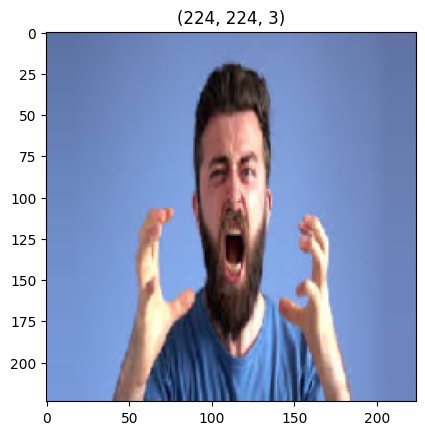

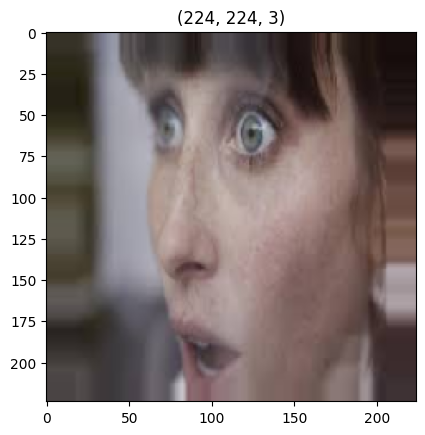

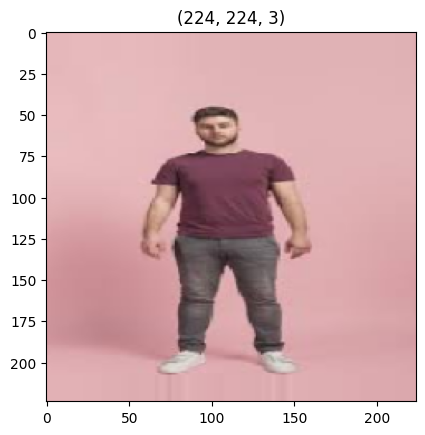

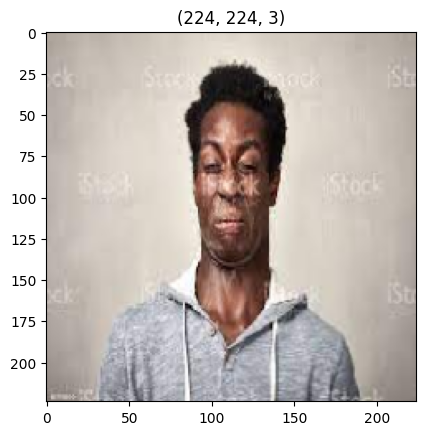

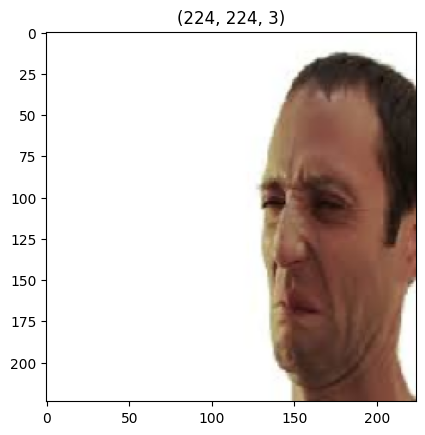

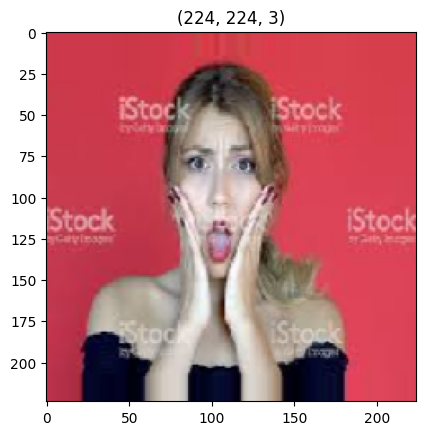

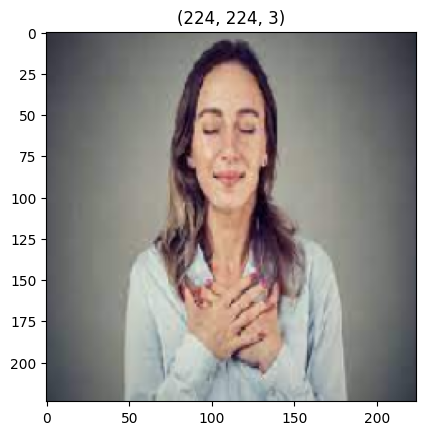

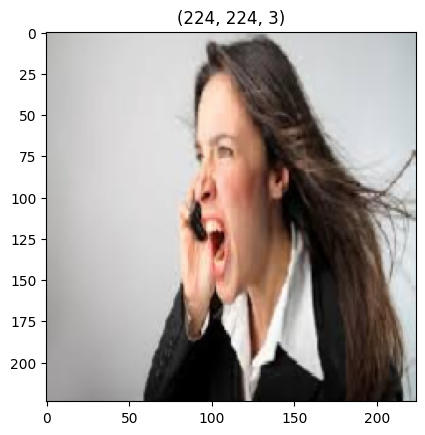

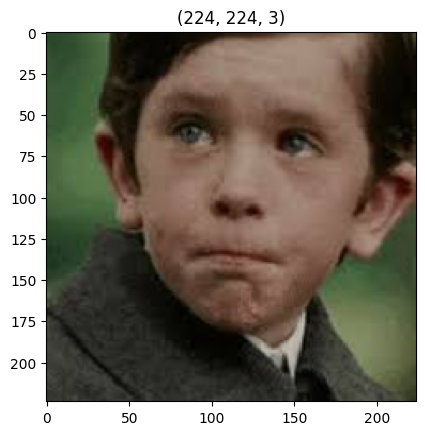

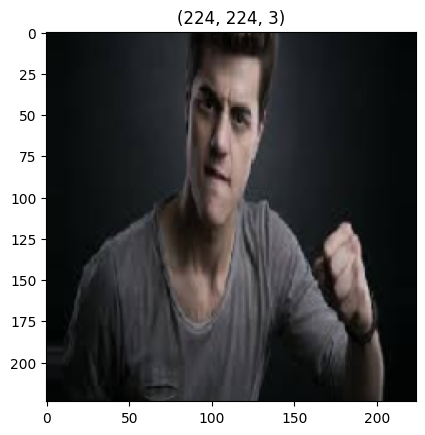

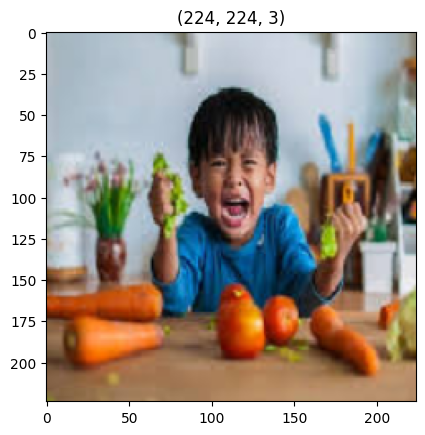

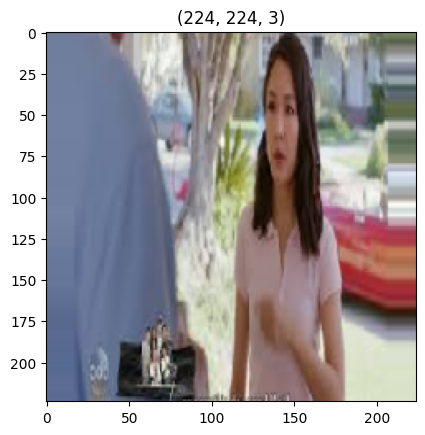

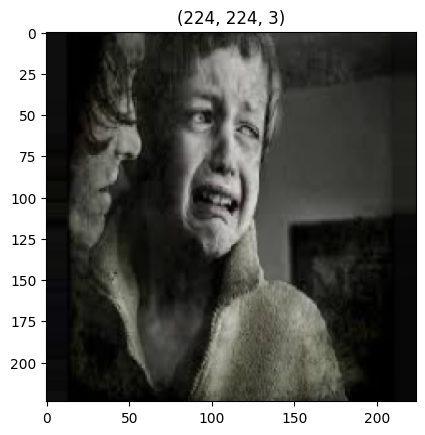

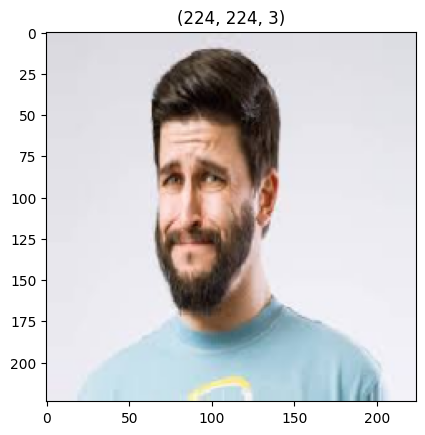

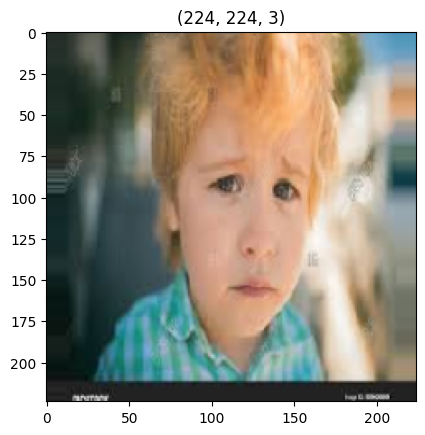

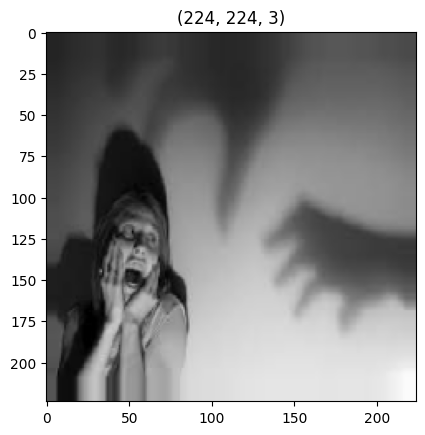

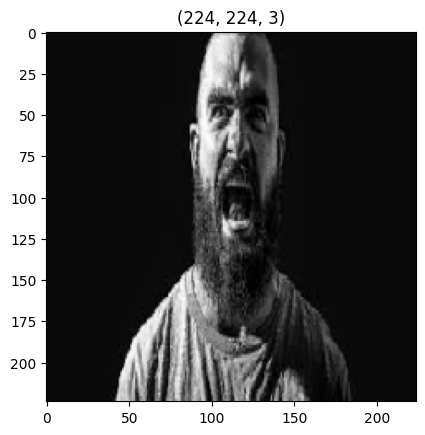

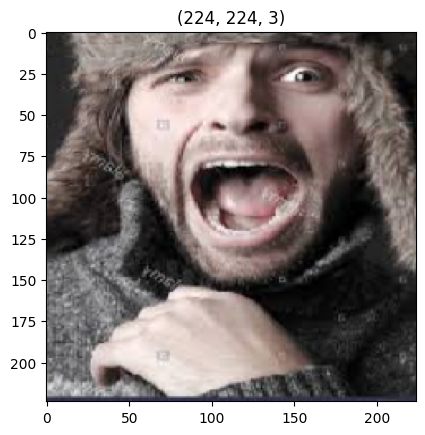

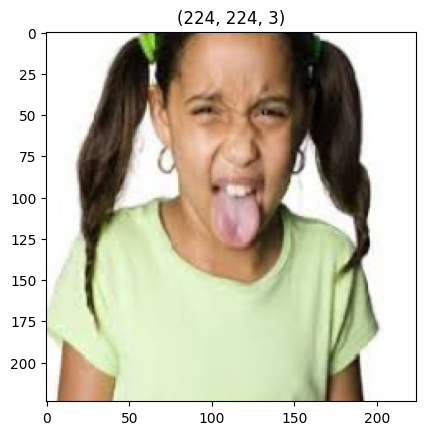

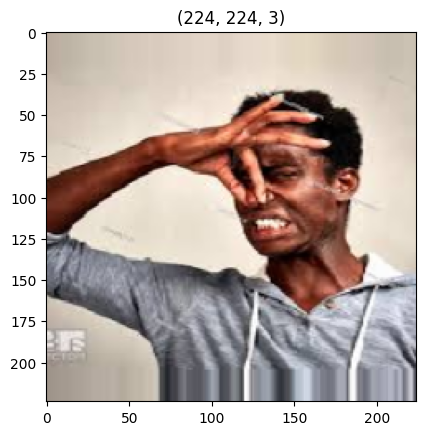

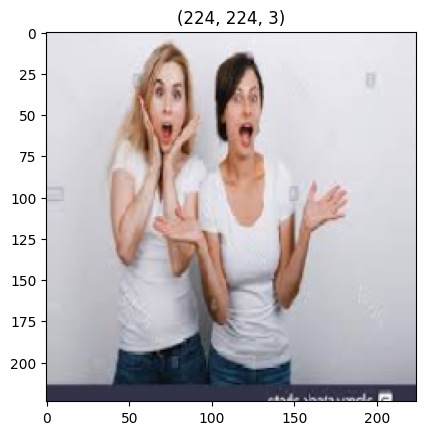

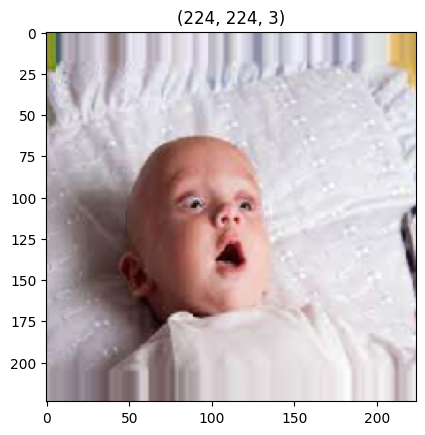

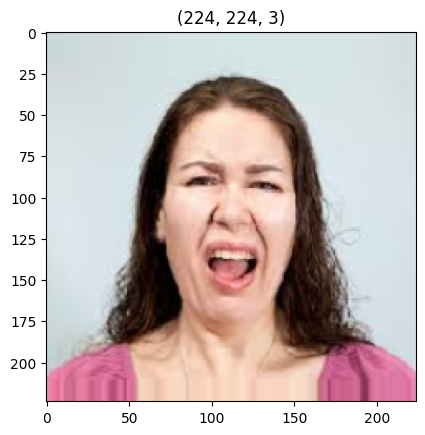

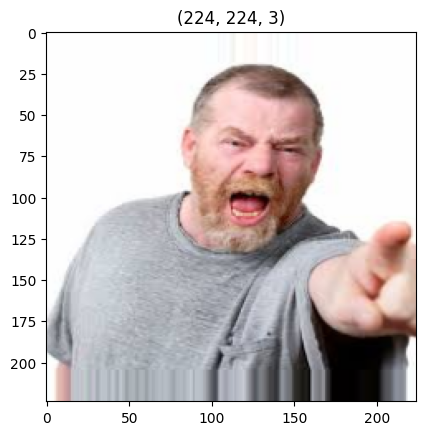

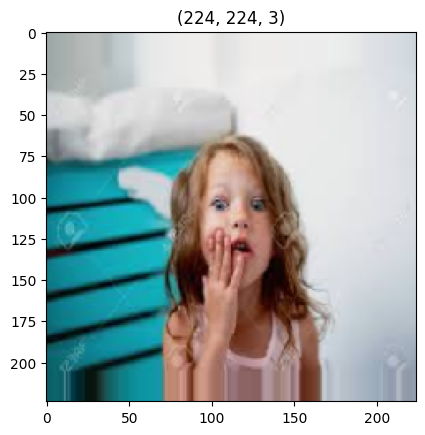

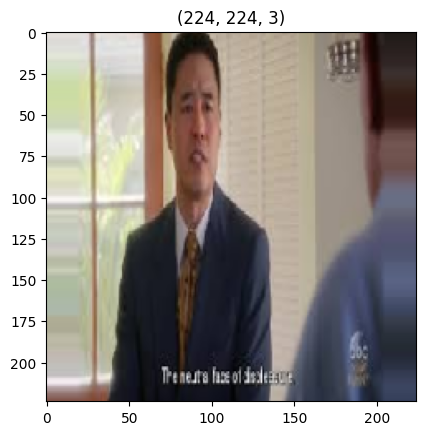

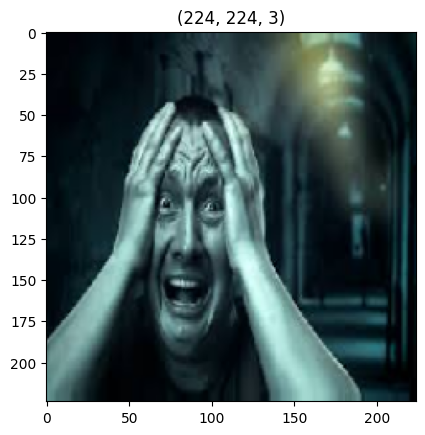

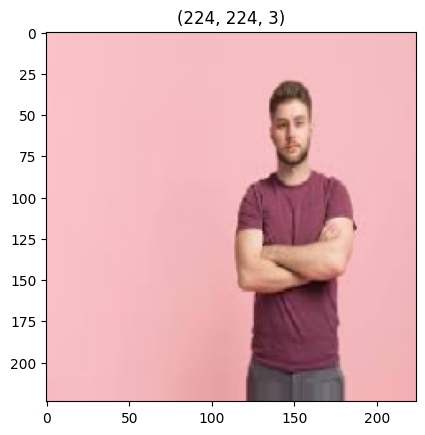

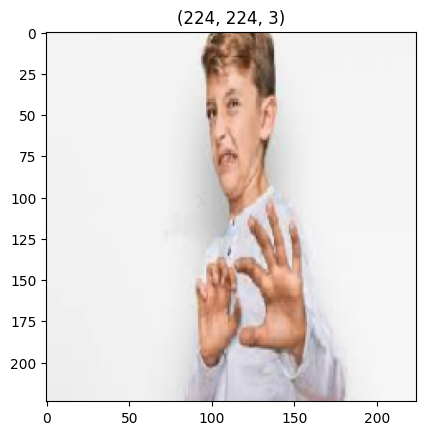

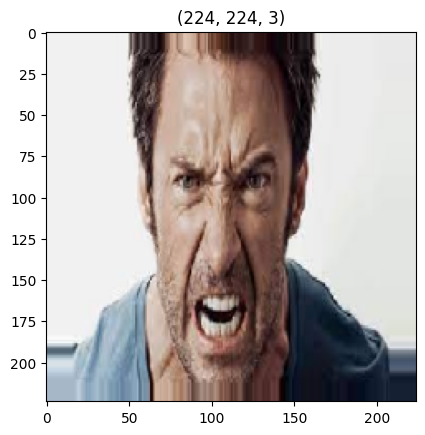

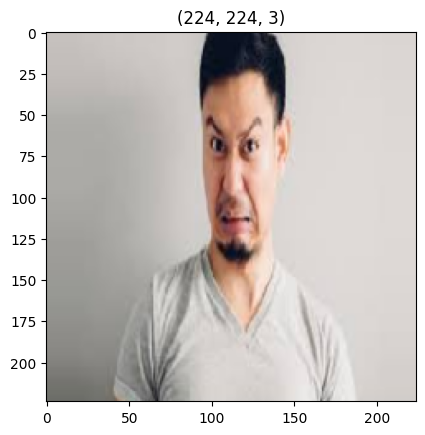

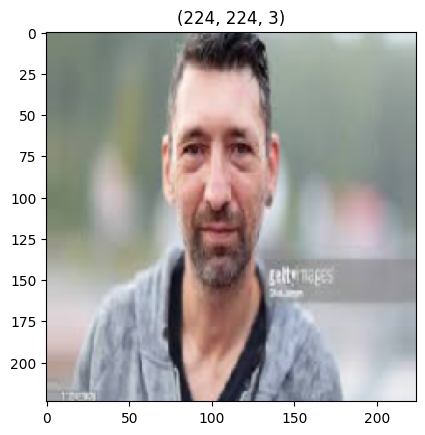

In [14]:
# visualizing the data

t_img, label=train_data.next()
def plotImages(img_arr, label):
  count=0
  for im,l in zip(img_arr,label):
    plt.imshow(im)
    plt.title(im.shape)
    plt.axiz=False
    plt.show()
    count+=1
    if(count==0):
      break
plotImages(t_img,label)

In [16]:
# early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

es=EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=5,verbose=1, mode='auto')

mc=ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='auto')

call_back=[es,mc]

In [17]:
hist=model.fit_generator(train_data,
                         steps_per_epoch=10,
                         epochs=30,
                         validation_data=val_data,
                         validation_steps=8,
                         callbacks=[es,mc])

<ipython-input-17-946ae87e46cd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 14.7516 - accuracy: 0.1730
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 30s 3s/step - loss: 14.7516 - accuracy: 0.1730 - val_loss: 6.9237 - val_accuracy: 0.3750
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 5.4553 - accuracy: 0.5126
Epoch 2: val_accuracy improved from 0.37500 to 0.68359, saving model to best_model.h5
10/10 [==============================] - 37s 4s/step - loss: 5.4553 - accuracy: 0.5126 - val_loss: 1.9268 - val_accuracy: 0.6836
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.5475 - accuracy: 0.7296
Epoch 3: val_accuracy improved from 0.68359 to 0.85156, saving model to best_model.h5
10/10 [==============================] - 39s 4s/step - loss: 1.5475 - accuracy: 0.7296 - val_loss: 0.5676 - val_accuracy: 0.8516
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.7893
Epoch 4: val_accuracy improved from 0.85156 to 0.89453, saving model to best_model.h5
10/10 [==============================] - 37s 4s/step - loss: 1.0196 - ac

In [18]:
#loading the best fit model
from keras.models import load_model
model=load_model("/content/best_model.h5")

In [19]:
h=hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

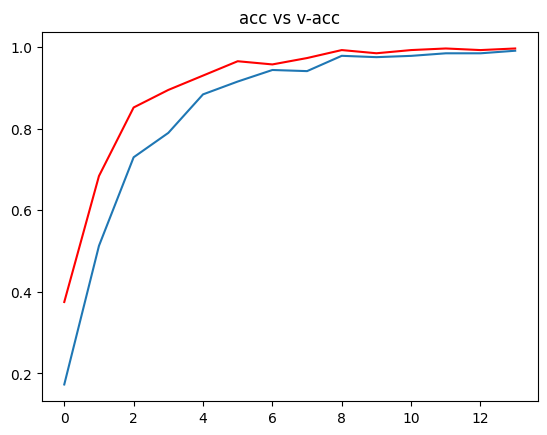

In [20]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title("acc vs v-acc")
plt.show()

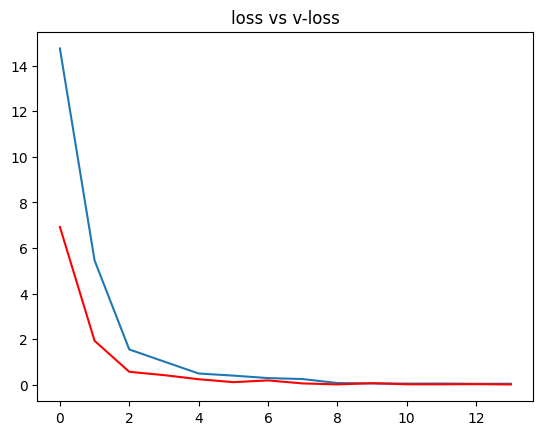

In [21]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs v-loss")
plt.show()

In [24]:
op=dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 [==============================] - 0s 97ms/step
The image is of Happy


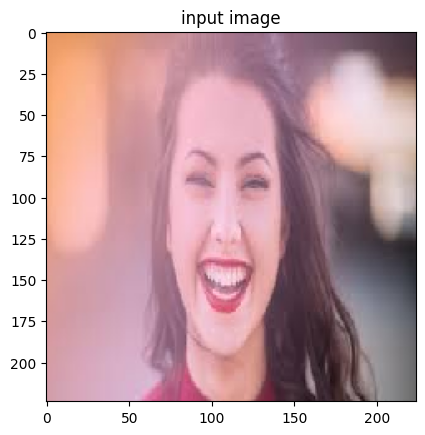

In [26]:
path="/content/download (1).jpg"
img=load_img(path,target_size=(224,224))
i=img_to_array(img)/255
input_arr=np.array([i])
input_arr.shape

pred=np.argmax(model.predict(input_arr))
print(f"The image is of {op[pred]}")

plt.imshow(input_arr[0])
plt.title('input image')
plt.show()